<a href="https://colab.research.google.com/github/javier-jaime/Tool-Crib/blob/master/Quantum_Optimization/D_Wave_Quantum_Annealers_for_Graph_Analytics_Colab_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# D-Wave Quantum Annealers for Graph Analytics Tutorial

In this tutorial we will use quantum annealers (a special type of quantum computers) from D-Wave online, to approximate solutions to combinatorial optimization problems for graph analytics.

This tutorial is based on code from: A Practical Guide to Quantum Machine Learning and Quantum Optimization by Elias F. Combarro & Samuel Gonzalez-Castillo (2023) https://github.com/PacktPublishing/A-Practical-Guide-to-Quantum-Machine-Learning-and-Quantum-Optimization

### Notebook Preparation

In order to access D-Wave quantum annealers from a Notebook (Jupyter or Colab) first we need to sign up for a D-Wave account: https://cloud.dwavesys.com/leap/signup/. This will give you a free minute, you will need to copy the token for use at set-up.

In [ ]:
# Install d-wave ocean libraries the first time, comment/uncomment as required
!pip install dwave-ocean-sdk==6.0.1

In [ ]:
# Set-up access to D-Wave quantum annealers
# enter token when prompted (click and paste right after Authentication token [...]:)
! dwave config create -p defaults

### Simple Max-Cut Problem

In a graph, some given *elements* are represented as **nodes** or vertices, and the *connections* between pairs of these nodes are called **relationships** or edges.

The **Max-Cut problem** consists in finding a maximum cut of a graph. So, we want to divide the nodes of the graph in two sets such that the number of relationships with extremes in different set of the cut is the maximum possible, this number is the size of the cut.

For example, in a community building networking event, the relationships represent the people that already know each other, and we need to form teams trying to minimize the people that know each other, so they can work with new people.

We start with a very simple instance of the Max-Cut problem to show how easy be transformed into quantum form, consider this graph:

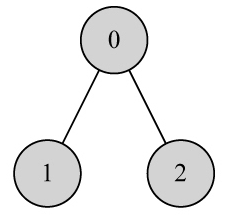

The Max-Cut problem can be written as follows:

Minimize      $Z_0Z_1 + Z_0Z_2$

Subject to     $Z_j \in \{-1,1\},  ~ \forall j$

Variables $Z_j$ are assigned to a node and will take the value 1 or -1, each assignment determines a cut, variables that take 1 will be in one set and variables that take -1 will be in another set. When two nodes are in the same set, the objective function results in 1, and when in different sets the function results to -1.

In [ ]:
# If you don't like physics you can skip this paragraph

This can be seen as a case of an unrelated problem in statistical physics: finding the state of **minimum energy** of an instance of the **Ising Model**, this is a math model for the ferromagnetic interaction of particles with spin, usually arranged in a lattice. The particle spins are represented by variables $Z_j$ that can take values 1 (spin up) or -1 (spin down). The $J$ coefficients represent the interaction between particles, and $h$ represents the influence of an external field.

The total energy of the system is given by a quantity called the Hamiltonian function, so in quantum terms the math model of the max-cut problem is equivalent to found the ground state of:
$Z_0Z_1 + Z_0Z_2$ which is an Ising Hamiltonian in which $J_{01} = J_{02} = 1$ and the $h$ coefficient is 0.

Finding the state of minimum energy of the system consists in obtaining a spin configuration for which the Hamiltonian function attains its minimum value.

To specify the problem we can use the dimod package included in the D-Wave Ocean library, as follows:

In [ ]:
import dimod
J = {(0,1):1, (0,2):1}
h = {}
problem = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
print("The problem we are going to solve is:")
print(problem)


The problem we are going to solve is:
BinaryQuadraticModel({0: 0.0, 1: 0.0, 2: 0.0}, {(1, 0): 1.0, (2, 0): 1.0}, 0.0, 'SPIN')


Note:

 - We used $J$ for the coefficients of the degree 2 terms: (0,1):1 sets the $J_{01}$ coefficient to 1 and (0,2):1 sets the $J_{02}$ coefficient to 1 and $h$ for the linear ones, if we don't specify the coefficients, they are automatically set to 0 by the constructor, but we need to pass both $J$ and $h$ parameters.

 - We used 0.0 as the value for the offset (second parameter) which is a constant term that can be added to the Hamiltonian.
 - We used the dimod.SPIN parameter because we are working with and Ising Hamiltonian, so the values of the variables are 1 and -1.

 The following code runs the annealing process on one of the quantum annealers:

In [ ]:
# Access the quantum annealers
from dwave.system import DWaveSampler

# Map or embed the problem in the qubits
from dwave.system import EmbeddingComposite

# Create an object sampler
sampler = EmbeddingComposite(DWaveSampler())

# Obtain 10 samples or possible solutions
result = sampler.sample(problem, num_reads=10)
print("The solutions that we have obtained are")
print(result)

The solutions that we have obtained are
   0  1  2 energy num_oc. chain_.
0 +1 -1 -1   -2.0       6     0.0
1 -1 +1 +1   -2.0       4     0.0
['SPIN', 2 rows, 10 samples, 3 variables]


This means that we obtained 2 different solutions $Z_0 = 1$, $Z_1 = -1$, $Z_2 = -1$ and $Z_0 = -1$, $Z_1 = 1$, $Z_2 = 1$ both with energy -2. These two solutions are, the maximum cuts of the graph. As you can easily check the two sets assigned to 1 and -1 in the graph above.

In [ ]:
# We can get additional information from the result

print('The best solution is:\n', result.first)
print ('\n Access Time', result.info['timing']['qpu_access_time'], 'microseconds')

The best solution is:
 Sample(sample={0: 1, 1: -1, 2: -1}, energy=-2.0, num_occurrences=6, chain_break_fraction=0.0)

 Access Time 16479.17 microseconds


The time to be substracted from the free plan is only 0.0165 seconds.

This simple problem escale well, defining how well depends on [computational complexity](https://github.com/javier-jaime/Tool-Crib/blob/master/Quantum%20Optimization/Appendix%20C%20-%20Computational%20Compexity.pdf).

### Binary Linear Programming

In **Binary Linear Programming** problems we want to optimize a linear function on binary variables subject to linear constraints.

An example of this type of problem can be written as follows:

Minimize      $-5X_0 + 3X_1 - 2X_2$

Subject to $A_x\leq  b,$  
$\\X_j\in \{0,1\},  ~ j=0,1,2.$

   

In *dimod* in order to instantiate a binary linear program, first we need to define the variables that we want to use.

In [ ]:
x0 = dimod.Binary("x0")
x1 = dimod.Binary("x1")
x2 = dimod.Binary("x2")

Then we need to define a *ConstrainedQuadraticModel* object, set the objective function and fix the constraints.

In [ ]:
blp = dimod.ConstrainedQuadraticModel()
blp.set_objective(-5*x0+3*x1-2*x2)
blp.add_constraint(x0 + x2 <= 1, "First constraint")
blp.add_constraint(3*x0 -x1 + 3*x2 <= 4, "Second constraint")

'Second constraint'

We can check the elements of the *blp* object by accessing its variables, objective, and constraints attributes.

In [ ]:
print("Our variables are:")
print(blp.variables)
print("Our objective is:")
print(blp.objective)
print("Our constraints are:")
print(blp.constraints)

Our variables are:
Variables(['x0', 'x1', 'x2'])
Our objective is:
ObjectiveView({'x0': -5.0, 'x1': 3.0, 'x2': -2.0}, {}, 0.0, {'x0': 'BINARY', 'x1': 'BINARY', 'x2': 'BINARY'})
Our constraints are:
{'First constraint': Le(ConstraintView({'x0': 1.0, 'x2': 1.0}, {}, 0.0, {'x0': 'BINARY', 'x2': 'BINARY'}), 1.0), 'Second constraint': Le(ConstraintView({'x0': 3.0, 'x1': -1.0, 'x2': 3.0}, {}, 0.0, {'x0': 'BINARY', 'x1': 'BINARY', 'x2': 'BINARY'}), 4.0)}


Note that the objective and the constrains are quadratic functions, only the linear part of the constraints is non-empty, the offset of zero and the constrainst are instances of the *dimod* *Le* class, for less than equal to.

We can assign values to the variables, check if it is feasible and compute the cost for the problem previously defined.

In [ ]:
sample1 = {"x0":1, "x1":1, "x2":1}
print("The assignment is", sample1)
print("Its cost is", blp.objective.energy(sample1))
print("Is it feasible?",blp.check_feasible(sample1))
print("The violations of the constraints are")
print(blp.violations(sample1))

The assignment is {'x0': 1, 'x1': 1, 'x2': 1}
Its cost is -4.0
Is it feasible? False
The violations of the constraints are
{'First constraint': 1.0, 'Second constraint': 1.0}


This assignment is not feasible and the *violations* method give us the amount that excedded each inequality.

In [ ]:
sample2 = {"x0":0, "x1":0, "x2":1}
print("The assignment is", sample2)
print("Its cost is", blp.objective.energy(sample2))
print("Is it feasible?",blp.check_feasible(sample2))
print("The violations of the constraints are")
print(blp.violations(sample2))

The assignment is {'x0': 0, 'x1': 0, 'x2': 1}
Its cost is -2.0
Is it feasible? True
The violations of the constraints are
{'First constraint': 0.0, 'Second constraint': -1.0}


This assignment is feasible so no violation term is positive.

The *dimod* package also provides a "brute-force" exact solver that tries all posible assignments and sort them by cost.

In [ ]:
solver = dimod.ExactCQMSolver()
solution = solver.sample_cqm(blp)
print("The list of assignments is")
print(solution)

The list of assignments is
  x0 x1 x2 energy num_oc. is_sat. is_fea.
6  1  0  1   -7.0       1 arra...   False
2  1  0  0   -5.0       1 arra...    True
7  1  1  1   -4.0       1 arra...   False
3  1  1  0   -2.0       1 arra...    True
4  0  0  1   -2.0       1 arra...    True
0  0  0  0    0.0       1 arra...    True
5  0  1  1    1.0       1 arra...    True
1  0  1  0    3.0       1 arra...    True
['INTEGER', 8 rows, 8 samples, 3 variables]


The first number is the identifier, followed by the variables values, the cost or energy of the assignment, the number of times the solution was found, which constraints are satisfied and if the solution is feasible or not.

In [ ]:
feasible_sols = solution.filter(lambda s: s.is_feasible)
feasible_sols.first

Sample(sample={'x0': 1, 'x1': 0, 'x2': 0}, energy=-5.0, num_occurrences=1, is_satisfied=array([ True,  True]), is_feasible=True)

The first solution does not satisfy either of the two constraints, for the optimal solution we need to filter the unfeasible solutions.

The *ConstrainedQuadraticModel* cannot be used to define problems to run on quantum annealers, for this need the *BinaryQuadraticModel*.

### QUBO Model

The *dimod* *BinaryQuadraticModel*, in addition to Ising models can be used for Quadratic Unconstrained Binary Optimization (QUBO) Problems. In which we want to minimize quadratic expressions over binary variables with no restrictions (every combination of zeros and ones is valid).

To transform a binary linear problem to **QUBO**, first we need to convert the inequality constraints by adding **slack variables** and second we need to add the constraints as **penalty terms** to the objective function to minimize. Luckily, *dimod* provides the  *ConstrainedQuadraticModel* class that simplify the process.

A simple constrainied problem can be defined as this.

In [ ]:
y0, y1 = dimod.Binaries(["y0", "y1"])
cqm = dimod.ConstrainedQuadraticModel()
cqm.set_objective(-2*y0-3*y1)
cqm.add_constraint(y0 + 2*y1 <= 2);

We can transform the constrained model to unconstrained model with the *cqm_to_bqm* method.

Note that the constraints will be added in a penalty term with the lagrange multiplier as a coefficient.

In [ ]:
qubo, invert = dimod.cqm_to_bqm(cqm, lagrange_multiplier = 5)
print(qubo)

BinaryQuadraticModel({'y0': -17.0, 'y1': -23.0, 'slack_v8fc1599377b24bf592da116fadd1b61b_0': -15.0, 'slack_v8fc1599377b24bf592da116fadd1b61b_1': -15.0}, {('y1', 'y0'): 20.0, ('slack_v8fc1599377b24bf592da116fadd1b61b_0', 'y0'): 10.0, ('slack_v8fc1599377b24bf592da116fadd1b61b_0', 'y1'): 20.0, ('slack_v8fc1599377b24bf592da116fadd1b61b_1', 'y0'): 10.0, ('slack_v8fc1599377b24bf592da116fadd1b61b_1', 'y1'): 20.0, ('slack_v8fc1599377b24bf592da116fadd1b61b_1', 'slack_v8fc1599377b24bf592da116fadd1b61b_0'): 10.0}, 20.0, 'BINARY')


The results are assigned to a *invert* object, and a *qubo* object that has the specification of the cost function,

first is the linear part:

- $y_0$ has coefficient -17

- $y_1$ has coefficient -23

- slack variables have coefficient -15

then the quadratic part:

- $y_0y_1$ has coefficient 20

- the products of the slack variables have coefficients 10 & 20

and finally 20 is the offset, all variables are BINARY.

Now we can use a quantum annealer to solve the problem defined above.

In [ ]:
sampler = EmbeddingComposite(DWaveSampler())
result = sampler.sample(qubo, num_reads=10)
print("The solutions that we have obtained are")
print(result)

The solutions that we have obtained are
  slack_v8fc1599377b24bf592da116fadd1b61b_0 ... y1 energy num_oc. chain_.
0                                         0 ...  1   -3.0       7     0.0
1                                         0 ...  0   -2.0       2     0.0
2                                         1 ...  0   -2.0       1     0.0
['BINARY', 3 rows, 10 samples, 4 variables]


This output is not clear because we are looking at the solutions to the transformed problem with the slack variables default long names.

So we need the *invert* object from above, this object will help us retrieve the solutions to the original problem.

In [ ]:
samples = []
occurrences = []
for s in result.data():
    samples.append(invert(s.sample))
    occurrences.append(s.num_occurrences)
sampleset = dimod.SampleSet.from_samples_cqm(samples,cqm,
    num_occurrences=occurrences)
print("The solutions to the original problem are")
print(sampleset)

The solutions to the original problem are
  y0 y1 energy num_oc. is_sat. is_fea.
0  0  1   -3.0       7 arra...    True
1  1  0   -2.0       2 arra...    True
2  1  0   -2.0       1 arra...    True
['INTEGER', 3 rows, 10 samples, 2 variables]


Note:

- We created a *SampleSet* object to store the results from the samples obtained.

- We used the *invert* object to eliminate the slack variables.

- We used the *from_samples_cqm* method  to compute the energy without penalties.

- We used the number of occurrences to count how many times each solution is sampled.



We can use the *filter* method to only keep feasible solutions, and the *aggregate* method to merge the duplicated solutions.

In [ ]:
final_sols = sampleset.filter(lambda s: s.is_feasible)
final_sols = final_sols.aggregate()
print("The final solutions are")
print(final_sols)

The final solutions are
  y0 y1 energy num_oc. is_sat. is_fea.
0  0  1   -3.0       7 arra...    True
1  1  0   -2.0       3 arra...    True
['INTEGER', 2 rows, 10 samples, 2 variables]


The output is now clear.

### The Leap Annealers

We can list the deviced we have access by using the *get_solvers* method.

In [ ]:
from dwave.cloud import Client
for solver in Client.from_config().get_solvers():
    print(solver)

BQMSolver(id='hybrid_binary_quadratic_model_version2')
DQMSolver(id='hybrid_discrete_quadratic_model_version1')
StructuredSolver(id='Advantage_system4.1')
CQMSolver(id='hybrid_constrained_quadratic_model_version1')
StructuredSolver(id='Advantage2_prototype1.1')
StructuredSolver(id='Advantage_system6.2')


This is the result for a free account, and this will depends on your privileges.

We have access to 6 solvers, from which 3 are hybrids that combine classical and quantum solvers,

and the other 3 are the advantage, that are pure quantum annealers.

We can select a particular annealer by using the solver parameter in the *DWaveSampler* constructor.

In [ ]:
from dwave.system import DWaveSampler
sampler=DWaveSampler(solver='Advantage_system6.2')
print("Name:",sampler.properties["chip_id"])
print("Number of qubits:",sampler.properties["num_qubits"])
print("Category:",sampler.properties["category"])
print("Supported problems:",sampler.properties["supported_problem_types"])
print("Topology:",sampler.properties["topology"])
print("Range of reads:",sampler.properties["num_reads_range"])

Name: Advantage_system6.2
Number of qubits: 5760
Category: qpu
Supported problems: ['ising', 'qubo']
Topology: {'type': 'pegasus', 'shape': [16]}
Range of reads: [1, 10000]


And print the *properties* with the sampler attribute.

In [ ]:
sampler=DWaveSampler(solver='Advantage_system4.1')
print("Name:",sampler.properties["chip_id"])
print("Number of qubits:",sampler.properties["num_qubits"])
print("Category:",sampler.properties["category"])
print("Supported problems:",sampler.properties["supported_problem_types"])
print("Topology:",sampler.properties["topology"])
print("Range of reads:",sampler.properties["num_reads_range"])

Name: Advantage_system4.1
Number of qubits: 5760
Category: qpu
Supported problems: ['ising', 'qubo']
Topology: {'type': 'pegasus', 'shape': [16]}
Range of reads: [1, 10000]


In [ ]:
sampler=DWaveSampler(solver='Advantage2_prototype1.1')
print("Name:",sampler.properties["chip_id"])
print("Number of qubits:",sampler.properties["num_qubits"])
print("Category:",sampler.properties["category"])
print("Supported problems:",sampler.properties["supported_problem_types"])
print("Topology:",sampler.properties["topology"])
print("Range of reads:",sampler.properties["num_reads_range"])

Name: Advantage2_prototype1.1
Number of qubits: 576
Category: qpu
Supported problems: ['ising', 'qubo']
Topology: {'type': 'zephyr', 'shape': [4, 4]}
Range of reads: [1, 10000]


Most of the properties are the same, all annealers are *qpu* or quantum processing units and all accept QUBO or Ising problems, the maximum number of examples is 10,000.


But current quantum computers does not connect the qubits all-to-all, this will be technically too difficult, ussually each qubit connect just to its neighbours by using *couplings*, so the ising model will have non-zero coefficients between the linked qubits. The way how the qubits are connected on a quantum processor is called **topology** and it is important for the design of the algorithms, and this topology and the number of qubits are the different properties between the annealers.


We can list all the connection with the *couplers* property, or in a more readable form using the adjecency method, but in most cases it is to big to print.

In [ ]:
# Too bing to print, uncomment at your own risk
# sampler=DWaveSampler(solver='Advantage_system6.2')
# print("Couplings:",sampler.properties["couplers"])
#sampler.adjacency

### Embedings

We need **embeddings** to map the problem Hamiltonian qubits to the annealers phyisical qubits.

But the mapping is not ussually one to one, in this case can use a **chain** of several physical qubits to represent a single qubit from the problem. The *dimod* package from the Ocean library takes care of this.   

In [ ]:
# Define the problem
J = {(0,1):1, (0,2):1, (1,2):1}
h = {}
triangle = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
# Embed it and solve it on the DW_2000Q_6 annealer
sampler = EmbeddingComposite(DWaveSampler(solver = "Advantage_system6.2"))
result = sampler.sample(triangle, num_reads=10,
    return_embedding = True)
print("The samples obtained are")
print(result)
print("The embedding used was")
print(result.info["embedding_context"])

The samples obtained are
   0  1  2 energy num_oc. chain_.
0 -1 -1 +1   -1.0       1     0.0
1 -1 +1 -1   -1.0       1     0.0
2 -1 +1 +1   -1.0       3     0.0
3 +1 +1 -1   -1.0       2     0.0
4 +1 -1 +1   -1.0       3     0.0
['SPIN', 5 rows, 10 samples, 3 variables]
The embedding used was
{'embedding': {1: (4331,), 0: (2092,), 2: (4346,)}, 'chain_break_method': 'majority_vote', 'embedding_parameters': {}, 'chain_strength': 1.9996979771955565}


In [ ]:
sampler = DWaveSampler(solver = "Advantage_system4.1")
print("The default annealing time is",
    sampler.properties["default_annealing_time"],"microseconds")
print("The possible values for the annealing time (in microseconds)"\
    " lie in the range",sampler.properties["annealing_time_range"])

The default annealing time is 20.0 microseconds
The possible values for the annealing time (in microseconds) lie in the range [0.5, 2000.0]


In [ ]:
J = {(0,1):1, (0,2):1, (1,2):1}
h = {}
triangle = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
sampler = EmbeddingComposite(DWaveSampler(solver = "Advantage_system6.2"))
result = sampler.sample(triangle, num_reads=10, annealing_time = 100)
print("The samples obtained are")
print(result)

The samples obtained are
   0  1  2 energy num_oc. chain_.
0 +1 -1 -1   -1.0       1     0.0
1 -1 -1 +1   -1.0       3     0.0
2 -1 +1 -1   -1.0       4     0.0
3 -1 +1 +1   -1.0       1     0.0
4 +1 +1 -1   -1.0       1     0.0
['SPIN', 5 rows, 10 samples, 3 variables]


In [ ]:
forward_schedule=[[0.0, 0.0], [5.0, 0.25], [25, 0.75], [30, 1.0]]
sampler = EmbeddingComposite(DWaveSampler())
result = sampler.sample(triangle, num_reads=10,
    anneal_schedule = forward_schedule)
print("The samples obtained are")
print(result)

The samples obtained are
   0  1  2 energy num_oc. chain_.
0 +1 -1 -1   -1.0       4     0.0
1 -1 -1 +1   -1.0       2     0.0
2 +1 -1 +1   -1.0       2     0.0
3 -1 +1 -1   -1.0       1     0.0
4 +1 +1 -1   -1.0       1     0.0
['SPIN', 5 rows, 10 samples, 3 variables]


In [ ]:
reverse_schedule=[[0.0, 1.0], [10.0, 0.5], [20, 1.0]]
initial_state = {0:1, 1:1, 2:1}
sampler = EmbeddingComposite(DWaveSampler())
result = sampler.sample(triangle, num_reads=10,
    anneal_schedule = reverse_schedule,
    reinitialize_state=False, initial_state = initial_state)
print("The samples obtained are")
print(result)

The samples obtained are
   0  1  2 energy num_oc. chain_.
0 -1 -1 +1   -1.0       1     0.0
1 -1 +1 -1   -1.0       1     0.0
2 +1 -1 +1   -1.0       1     0.0
3 -1 +1 -1   -1.0       1     0.0
4 -1 +1 +1   -1.0       1     0.0
5 +1 -1 +1   -1.0       1     0.0
6 +1 +1 -1   -1.0       1     0.0
7 +1 +1 -1   -1.0       1     0.0
8 +1 -1 +1   -1.0       1     0.0
9 -1 -1 +1   -1.0       1     0.0
['SPIN', 10 rows, 10 samples, 3 variables]


In [ ]:
sampler = DWaveSampler("Advantage_system4.1")
print("The coupling strength range is", sampler.properties["h_range"])

The coupling strength range is [-4.0, 4.0]


In [ ]:
sampler = EmbeddingComposite(DWaveSampler("Advantage_system4.1"))
# Define the problem
x0 = dimod.Binary("x0")
x1 = dimod.Binary("x1")
x2 = dimod.Binary("x2")
blp = dimod.ConstrainedQuadraticModel()
blp.set_objective(-5*x0+3*x1-2*x2)
blp.add_constraint(x0 + x2 <= 1, "First constraint")
blp.add_constraint(3*x0 -x1 + 3*x2 <= 4, "Second constraint")
# Convert the problem and run it
qubo, invert = dimod.cqm_to_bqm(blp, lagrange_multiplier = 10)
result = sampler.sample(qubo, num_reads=100)
# Aggregate and show the results
samples = []
occurrences = []
for s in result.data():
    samples.append(invert(s.sample))
    occurrences.append(s.num_occurrences)
sampleset = dimod.SampleSet.from_samples_cqm(samples,blp,
    num_occurrences=occurrences)
print("The solutions to the original problem are")
print(sampleset.filter(lambda s: s.is_feasible).aggregate())

The solutions to the original problem are
  x0 x1 x2 energy num_oc. is_sat. is_fea.
0  1  0  0   -5.0      36 arra...    True
1  0  0  1   -2.0      10 arra...    True
2  1  1  0   -2.0      32 arra...    True
3  0  0  0    0.0       7 arra...    True
4  0  1  1    1.0      12 arra...    True
5  0  1  0    3.0       3 arra...    True
['INTEGER', 6 rows, 100 samples, 3 variables]


In [ ]:
# Convert the problem and run it
qubo, invert = dimod.cqm_to_bqm(blp, lagrange_multiplier = 4)
result = sampler.sample(qubo, num_reads=100)
# Aggregate and show the results
samples = []
occurrences = []
for s in result.data():
    samples.append(invert(s.sample))
    occurrences.append(s.num_occurrences)
sampleset = dimod.SampleSet.from_samples_cqm(samples,blp,
    num_occurrences=occurrences)
print("The solutions to the original problem are")
print(sampleset.filter(lambda s: s.is_feasible).aggregate())

The solutions to the original problem are
  x0 x1 x2 energy num_oc. is_sat. is_fea.
0  1  0  0   -5.0      40 arra...    True
1  1  1  0   -2.0      29 arra...    True
2  0  0  1   -2.0       7 arra...    True
3  0  0  0    0.0      10 arra...    True
4  0  1  1    1.0      10 arra...    True
5  0  1  0    3.0       4 arra...    True
['INTEGER', 6 rows, 100 samples, 3 variables]


In [ ]:
# Convert the problem and run it
qubo, invert = dimod.cqm_to_bqm(blp, lagrange_multiplier = 1)
result = sampler.sample(qubo, num_reads=100)
# Aggregate and show the results
samples = []
occurrences = []
for s in result.data():
    samples.append(invert(s.sample))
    occurrences.append(s.num_occurrences)
sampleset = dimod.SampleSet.from_samples_cqm(samples,blp,
    num_occurrences=occurrences)
print("The solutions to the original problem are")
print(sampleset.filter(lambda s: s.is_feasible).aggregate())

The solutions to the original problem are
  x0 x1 x2 energy num_oc. is_sat. is_fea.
0  1  0  0   -5.0      64 arra...    True
1  1  1  0   -2.0      14 arra...    True
2  0  0  1   -2.0       9 arra...    True
3  0  0  0    0.0       5 arra...    True
4  0  1  1    1.0       2 arra...    True
['INTEGER', 5 rows, 94 samples, 3 variables]


In [ ]:
import greedy
import dimod
# Define the problem
J = {(0,1):1, (1,2):1, (2,3):1, (3,0):1}
h = {}
problem = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
# Sample with SteepestDescentSolver
solver = greedy.SteepestDescentSolver()
solution = solver.sample(problem, num_reads = 10)
print(solution.aggregate())

   0  1  2  3 energy num_oc. num_st.
0 +1 -1 +1 -1   -4.0       3       1
1 -1 +1 -1 +1   -4.0       2       2
2 +1 -1 -1 +1    0.0       4       0
3 -1 +1 +1 -1    0.0       1       0
['SPIN', 4 rows, 10 samples, 4 variables]


In [ ]:
import tabu
solver = tabu.TabuSampler()
solution = solver.sample(problem, num_reads = 10)
print(solution.aggregate())

   0  1  2  3 energy num_oc. num_re.
0 +1 -1 +1 -1   -4.0       5       2
1 -1 +1 -1 +1   -4.0       5       2
['SPIN', 2 rows, 10 samples, 4 variables]


In [ ]:
import neal
solver = neal.SimulatedAnnealingSampler()
solution = solver.sample(problem, num_reads = 10)
print(solution.aggregate())

   0  1  2  3 energy num_oc.
0 +1 -1 +1 -1   -4.0       3
1 -1 +1 -1 +1   -4.0       3
2 +1 +1 -1 -1    0.0       2
3 +1 +1 +1 -1    0.0       1
4 -1 +1 +1 +1    0.0       1
['SPIN', 5 rows, 10 samples, 4 variables]


In [ ]:
import dwave.system
sampler = dwave.system.LeapHybridSampler()
solution = solver.sample(problem, num_reads = 10)
print(solution.aggregate())

   0  1  2  3 energy num_oc.
0 -1 +1 -1 +1   -4.0       5
1 +1 -1 +1 -1   -4.0       1
2 +1 +1 +1 -1    0.0       2
3 -1 +1 +1 +1    0.0       1
4 +1 -1 -1 -1    0.0       1
['SPIN', 5 rows, 10 samples, 4 variables]


In [ ]:
sampler.properties["quota_conversion_rate"]


20